# CSTAT Lab #9
This is the ninth lab of the computaitonal statistics course, covering time series decompositions, regression with autocorrelated errors, the cross correlation function and the periodogram. 

In [58]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

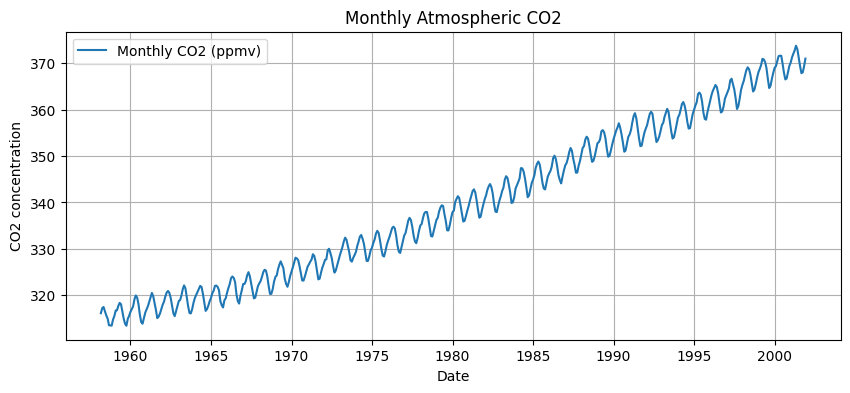

In [59]:
# Load monthly atmospheric CO2 from 1959 to 1997
data_co2 = sm.datasets.co2.load_pandas().data
# Convert to monthly frequency, interpolate missing
co2 = data_co2['co2'].resample('MS').mean().interpolate()

# Plot original series
t = co2.index
plt.figure(figsize=(10,4))
plt.plot(t, co2, label='Monthly CO2 (ppmv)')
plt.title('Monthly Atmospheric CO2')
plt.xlabel('Date')
plt.ylabel('CO2 concentration')
plt.grid(True)
plt.legend()
plt.show()

In the above graph we have plotted a dataset with the monthly atmospheric CO2 over a period in the 20th century. 

We perform an additive decomposition which you will replicate afterwards.

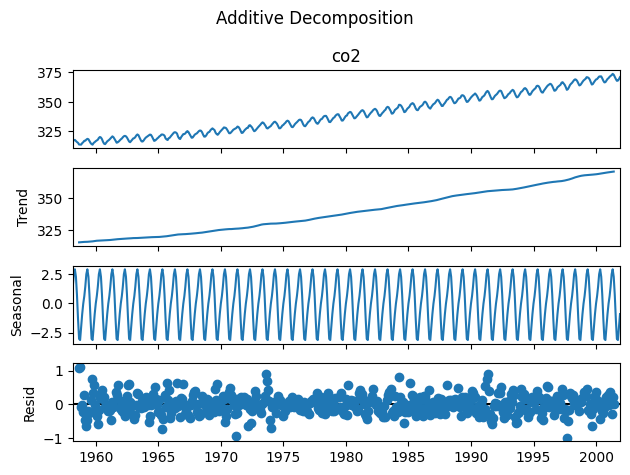

In [60]:
decomp_add = seasonal_decompose(co2, model='additive', period=12)
decomp_add.plot()
plt.suptitle('Additive Decomposition')
plt.tight_layout()
plt.show()

Next we perform a multiplicative decomposition

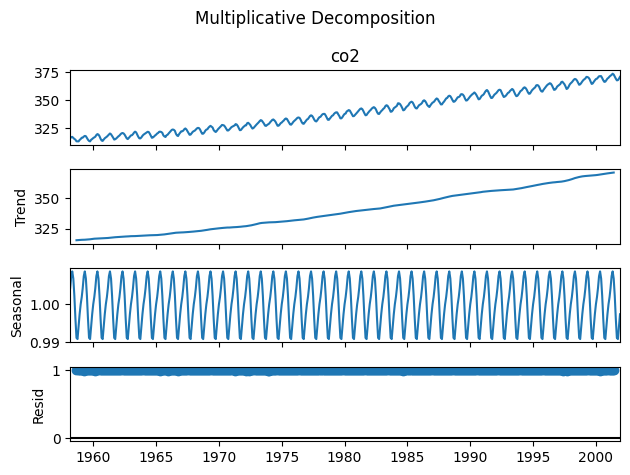

In [61]:
decomp_mul = seasonal_decompose(co2, model='multiplicative', period=12)
decomp_mul.plot()
plt.suptitle('Multiplicative Decomposition')
plt.tight_layout()
plt.show()

Compare the additive and multiplicative decompositions in terms of trend, seasonal amplitude and residuals. 

Manually compute the additive components by completing the code below.

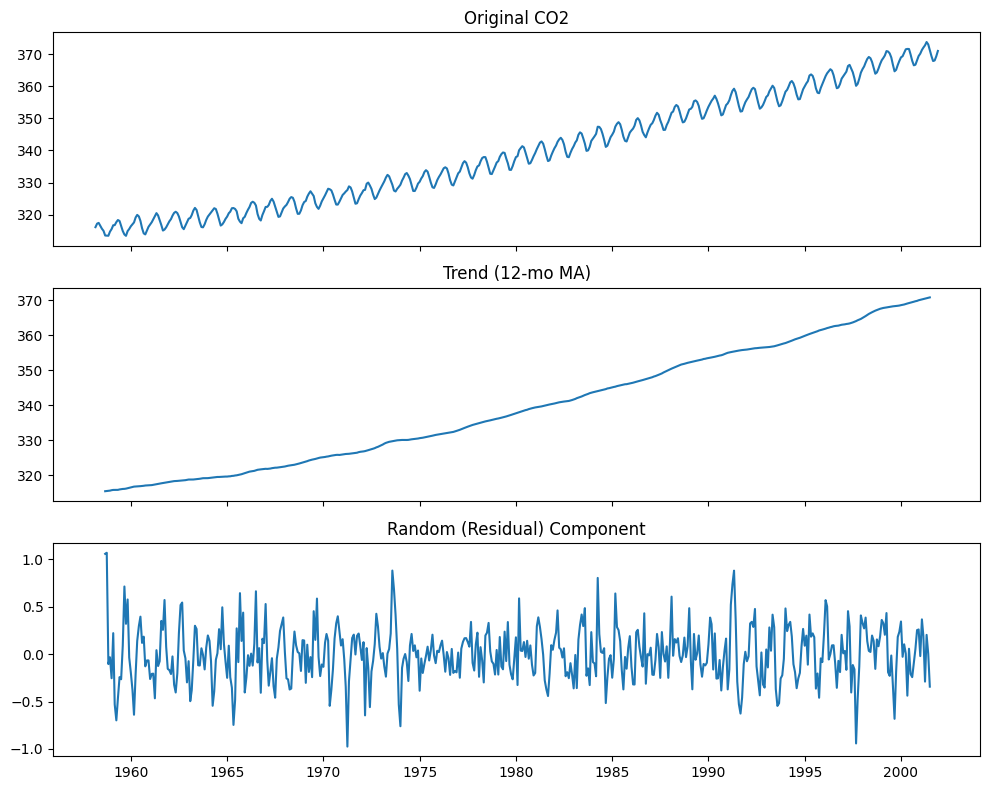

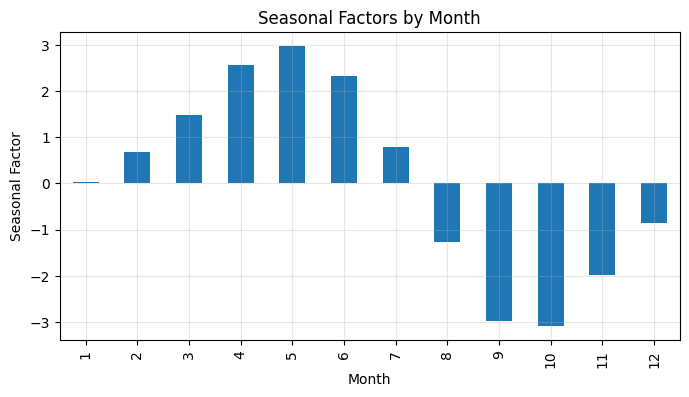

In [62]:
trend_ma = ...

# Detrend series 
detrended = ...
detrended_nonan = detrended.dropna()

# Estimate seasonal factors per month
seasonal_factors = detrended_nonan.groupby(detrended_nonan.index.month).mean()

# Map seasonal factors to full index
seasonal_index = co2.index.month.map(seasonal_factors)
random = ...

# Display seasonal factors table for clarity
sf_df = pd.DataFrame({
    'Month': range(1, 13),
    'Seasonal_Factor': seasonal_factors.values.flatten()
})
# Plot manual components
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(co2)
axs[0].set_title('Original CO2')
axs[1].plot(trend_ma)
axs[1].set_title('Trend (12-mo MA)')
axs[2].plot(random)
axs[2].set_title('Random (Residual) Component')
plt.tight_layout()
plt.show()

# Separate bar plot for seasonal factors for clarity
plt.figure(figsize=(8,4))
sf_df.set_index('Month')['Seasonal_Factor'].plot(kind='bar')
plt.title('Seasonal Factors by Month')
plt.xlabel('Month')
plt.ylabel('Seasonal Factor')
plt.grid(True, alpha=0.3)
plt.show()

Thus the Co2 dataset exhibits seasonality and an increasing trend. Let us attempt to detrend this data.
Next, implement a centered 12-month moving average (MA) manually by completing the code below. Comment whether you have succesfully smoothed out the seasonal volatility.


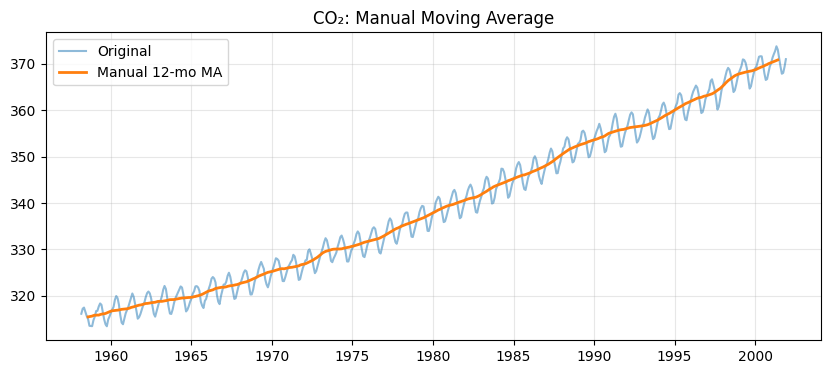

In [63]:
window = ...
... # Calculate moving average

# Plotting the moving average
ma_manual = pd.Series(manual_ma, index=co2.index)
plt.figure(figsize=(10,4))
plt.plot(co2, alpha=0.5, label='Original')
plt.plot(ma_manual, label='Manual 12‑mo MA', linewidth=2)
plt.title('CO₂: Manual Moving Average')
plt.legend();
plt.grid(True, alpha=0.3);
plt.show()

Implement single exponential smoothing manually in the code block below. Find a value of $\alpha$ that removes the seasonal volatility. 

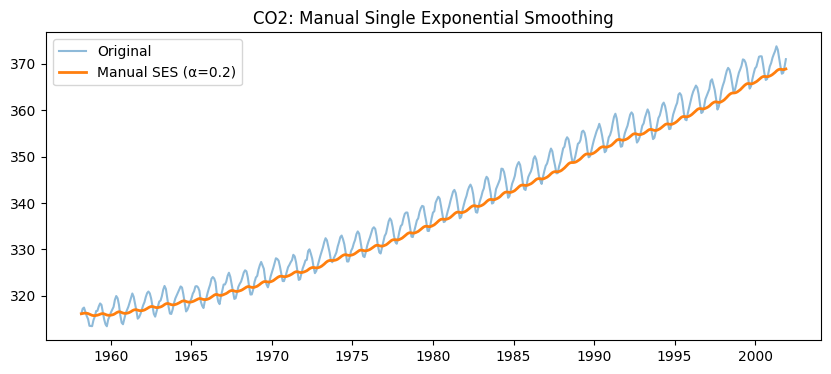

In [72]:
alpha = ...
... # Calculate SES manually

# Plotting the SES    
ses_manual = pd.Series(ses_manual, index=co2.index)
plt.figure(figsize=(10,4))
plt.plot(co2, alpha=0.5, label='Original')
plt.plot(ses_manual, label='Manual SES (α=0.2)', linewidth=2)
plt.title('CO2: Manual Single Exponential Smoothing')
plt.legend(); plt.show()

## Regression with AR(1) errors
We load quarterly data for gdp and consumption. Complete the code below regressing consumption on GDP and inspecting the ACF, PACF of the residuals. 
Analyze the coefficients and their p-values. Diagnose the autocorrelation of the residuals.

                            OLS Regression Results                            
Dep. Variable:               realcons   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.302e+05
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          1.34e-284
Time:                        16:16:12   Log-Likelihood:                -1202.8
No. Observations:                 203   AIC:                             2410.
Df Residuals:                     201   BIC:                             2416.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -366.7508     15.743    -23.296      0.0

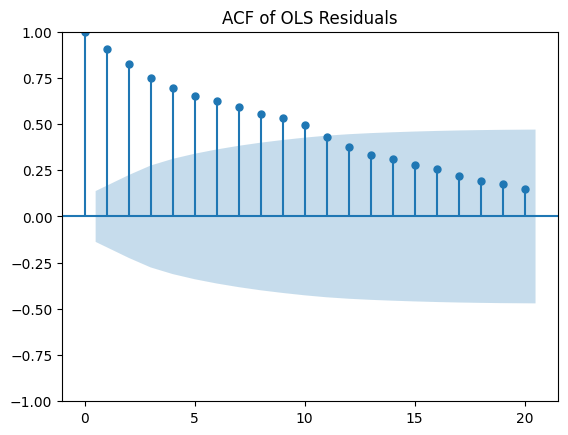

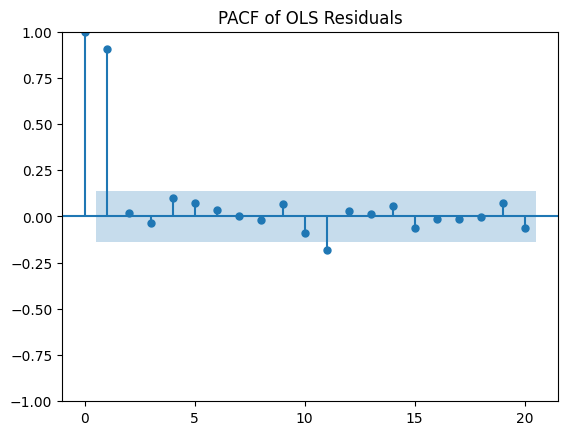

In [73]:
# Load quarterly macroeconomic data
macro = sm.datasets.macrodata.load_pandas().data
dates = pd.date_range(start='1959-01-01', periods=len(macro), freq='QS')
macro.index = dates
y = macro['realcons']  # consumption
x = macro['realgdp']   # GDP

# OLS regression y ~ x and residual diagnostics
X = ...
ols = ...
print(ols.summary())

# Plot ACF and PACF of residuals
...



Now estimate and AR(1) model on the residuals and refit the regression using the Cochrane-Orcutt transformation by completing the code below.

In [66]:


# Estimate AR(1) on residuals and apply Cochrane-Orcutt
from statsmodels.tsa.ar_model import AutoReg
ar_mod =  ...
phi = ar_mod.params.iloc[1]  # AR(1) coefficient
print(f"Estimated AR(1) phi: {phi:.4f}")

# Create transformed variables
y_star = ...
x_star = ...
ols_star = ...
print(ols_star.summary())

Estimated AR(1) phi: 0.9532
                            OLS Regression Results                            
Dep. Variable:               realcons   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     2718.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):          2.28e-118
Time:                        15:41:21   Log-Likelihood:                -986.35
No. Observations:                 202   AIC:                             1977.
Df Residuals:                     200   BIC:                             1983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.2344   

Analyze if the correction is necessary and what the impact is on the coefficients.


## Cross-Correlation Function (CCF)
Using the real investments of our macro dataset, compute the CCF between real investments and GDP.

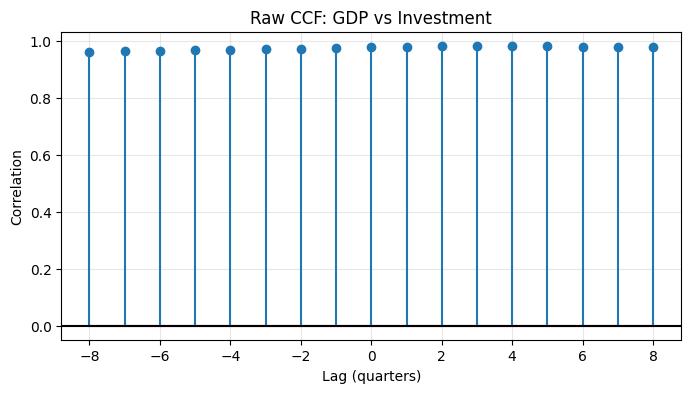

In [67]:
inv = macro['realinv']
lags = np.arange(-8, 9)

# Calculate cross-correlation function (CCF) between GDP and investment
ccf_values = ...

# Plot raw CCF
graph, ax = plt.subplots(figsize=(8,4))
ax.stem(lags, ccf_values)
ax.axhline(0, color='black')
ax.set_title('Raw CCF: GDP vs Investment')
ax.set_xlabel('Lag (quarters)')
ax.set_ylabel('Correlation')
plt.grid(True, alpha=0.3)
plt.show()

Analyze the CCF, determine if the result is spurious and why. 

Remove the trend from our GDP and investment data, recompute and plot the CCF.

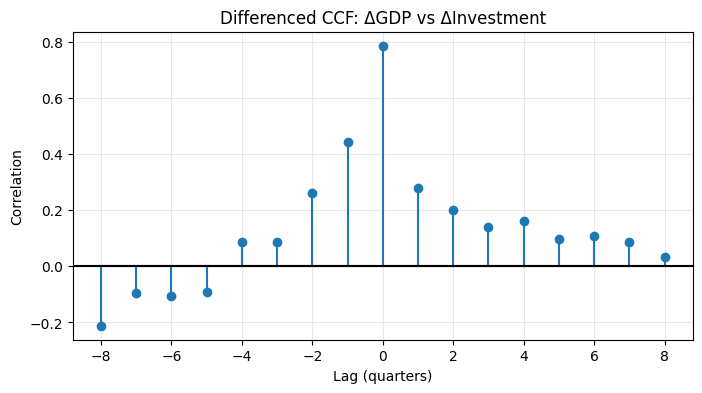

In [68]:
# First differences to remove trend
differenced_gdp = ...
differenced_investment = ...

# Compute CCF on differenced data
ccf_diff = ...

# Plot differenced CCF
graph, ax = plt.subplots(figsize=(8,4))
ax.stem(lags, ccf_diff)
ax.axhline(0, color='black')
ax.set_title('Differenced CCF: ΔGDP vs ΔInvestment')
ax.set_xlabel('Lag (quarters)')
ax.set_ylabel('Correlation')
plt.grid(True, alpha=0.3)
plt.show()

Analyze the CCF, determine if the result is spurious. Also state if GDP leads/lags investment. 

## Periodogram

Finally, we load a dataset containing sunspot activity plotted below.

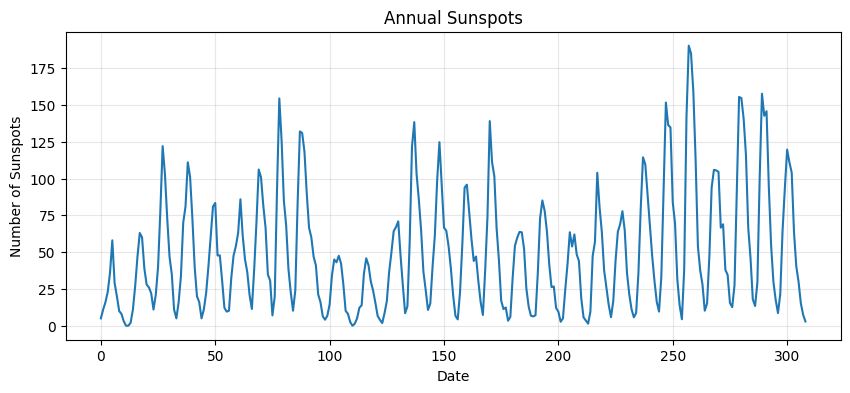

In [69]:
sunspots = sm.datasets.sunspots.load_pandas().data['SUNACTIVITY']

sunspots.plot(figsize=(10,4), title='Annual Sunspots')
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.grid(True, alpha=0.3)
plt.show()


In the code below, compute the detrended sunspot activity and determine the dominant frequency with the scipy periodogram function.
What is the dominant periodicity of sunspot activity in years? 

Dominant frequency: 0.0909 cycles/year = 11.00 years


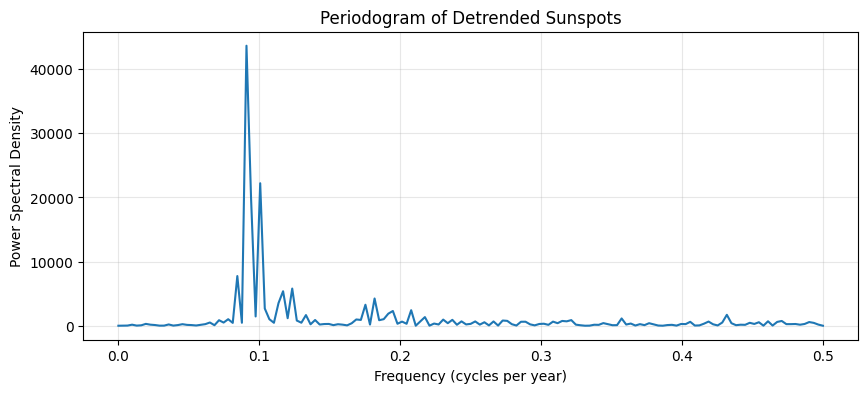

In [57]:

# Compute periodogram of detrended data
from scipy.signal import periodogram
freqs, psd = ...

# Determine dominant frequency
dominant_freq =  ...

# Plot periodogram: Power vs Frequency
plt.figure(figsize=(10,4))
plt.plot(freqs, psd)
plt.title('Periodogram of Detrended Sunspots')
plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Power Spectral Density')
plt.grid(True, alpha=0.3)
plt.show()
